In [1]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
from parameters import *
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm


plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': [r'\usepackage{amsmath}'],
    'figure.dpi': 140
})


In [2]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_fit_test.root'

branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
               'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID']
with uproot.open(file_path) as tree:
        hits_dict = tree['events'].arrays(branch_list, library="np")

df_hits = pd.DataFrame.from_dict(hits_dict)

In [3]:
def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i]] for i in range(len(row['barID'])) if row['EcalEdep'][i] > 0]

def create_tracks(df, plot=False):
    tracks = []
    true_parameters = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        layers = row['layerID']
        bars = row['barID']
        Edep = row['EcalEdep']
        hits = get_hits(row)
        hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 1]
        hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 0]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D()
            track.x = Track(hitsX)
            track.y = Track(hitsY)
            tracks.append(track)
            true_parameters.append([row['x0'], row['y0'] - (thickness + thickness_screen) * row['ty'], row['tx'], row['ty']])


    return tracks, true_parameters


In [4]:
tracks, true_parameters = create_tracks(df_hits)

100%|██████████| 10000/10000 [02:32<00:00, 65.73it/s]


####### Track # 9097
Real parameters:  x0 = 26.74, y0 = 22.69, t_x = 0.05, t_y = -0.04
Fit parameters:  x0 = 25.59, y0 = 24.50, t_x = 0.16, t_y = -0.17


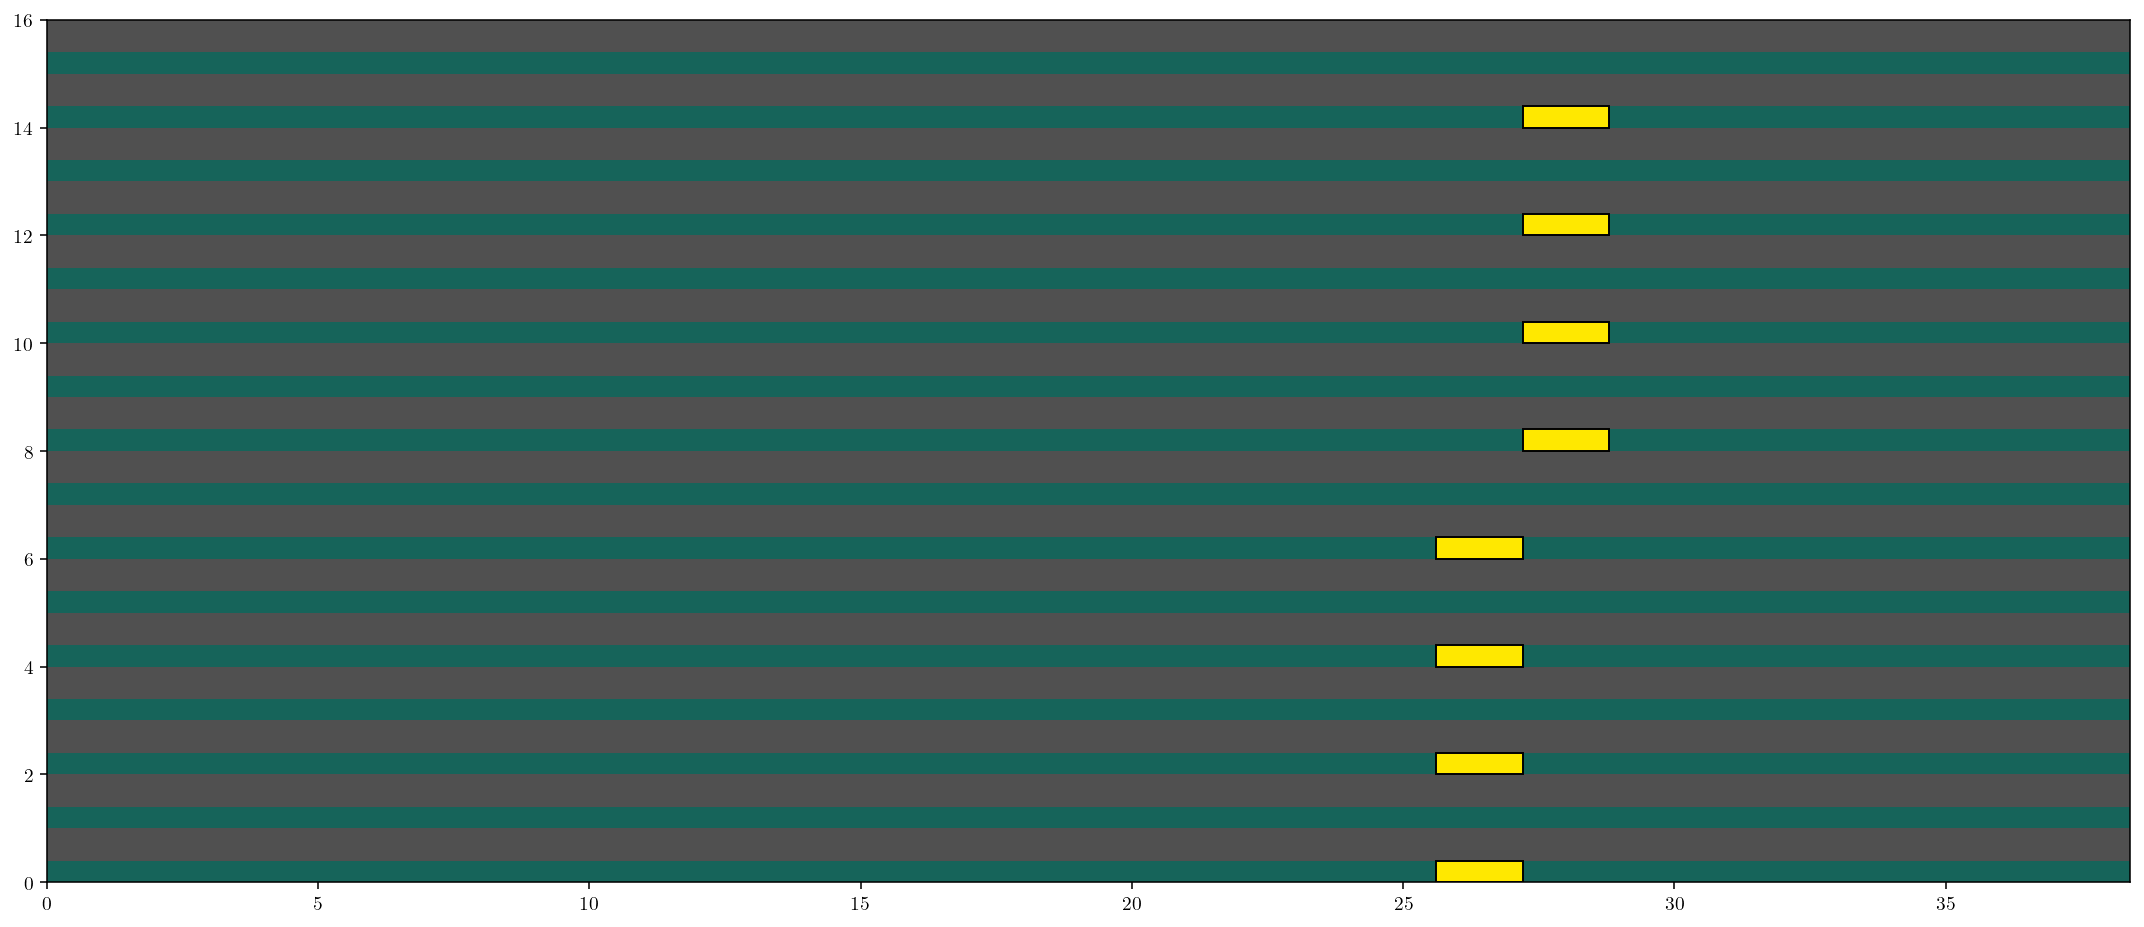

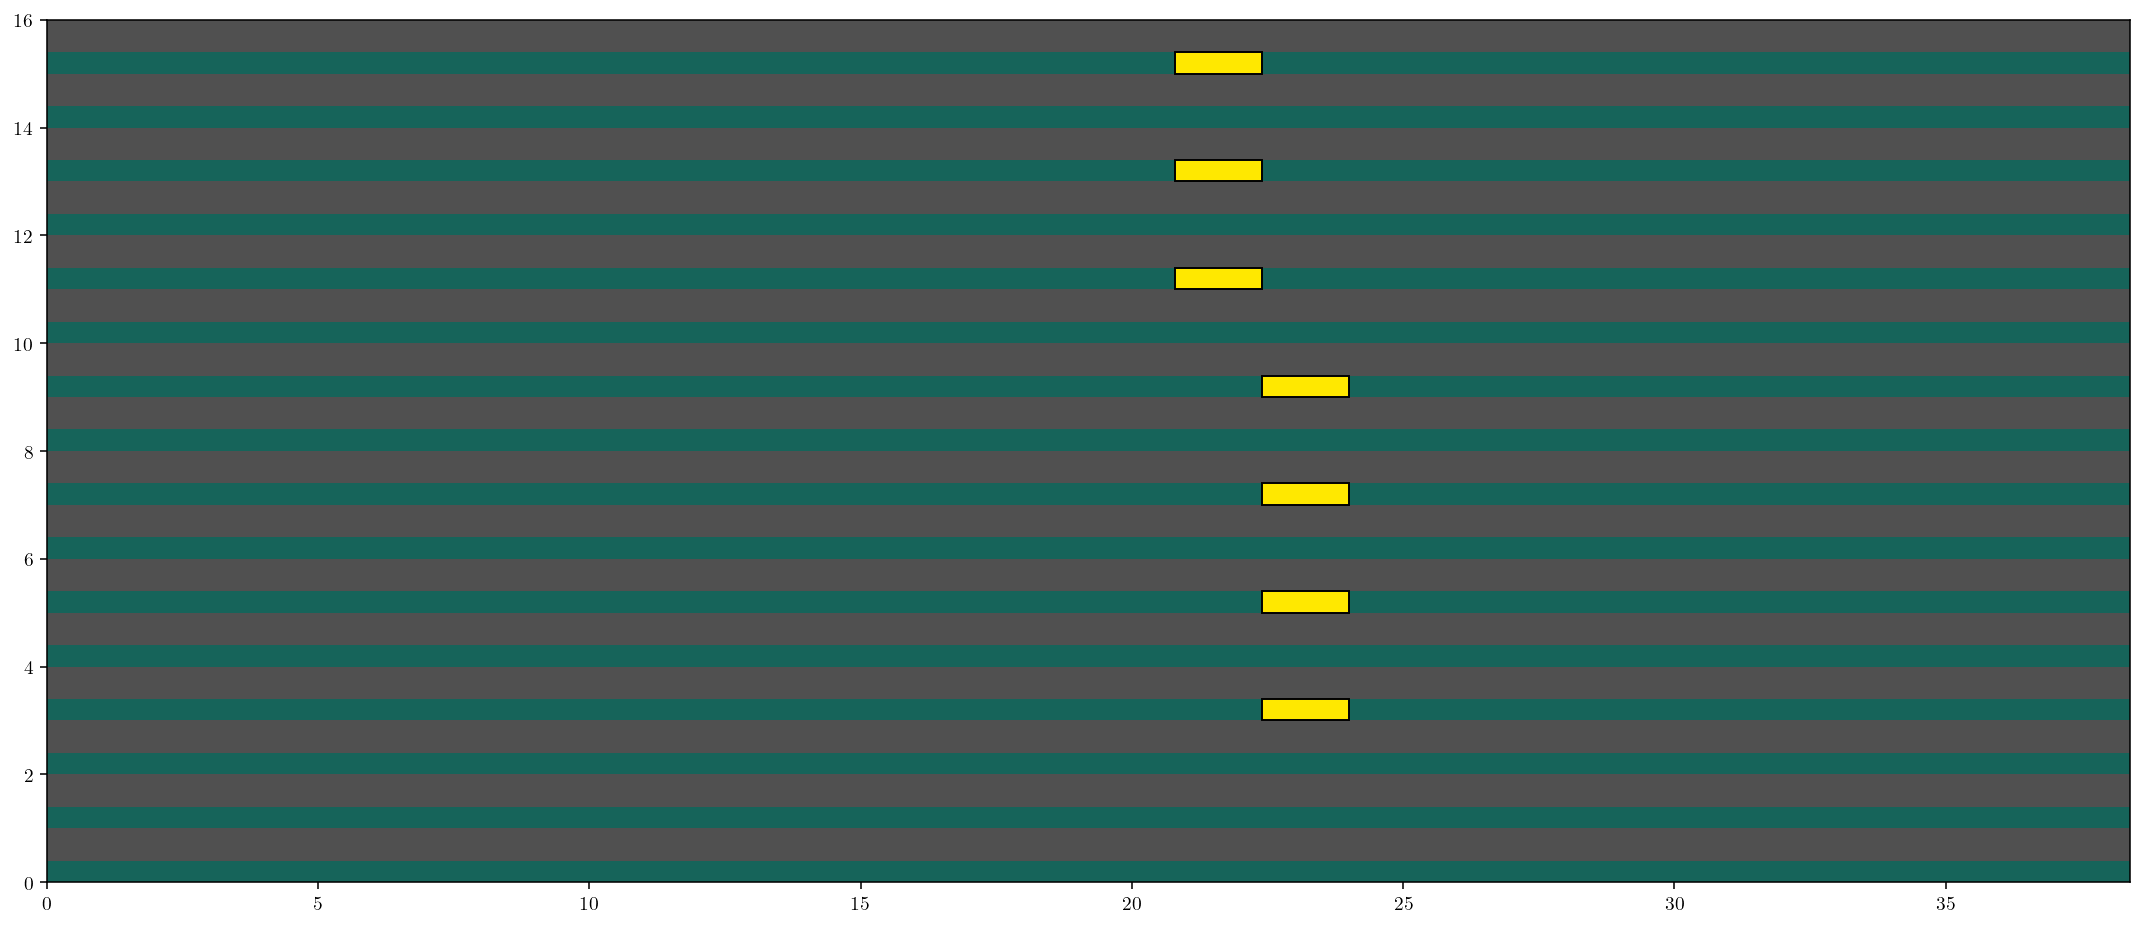

In [5]:
# testing individual outputs
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
true = true_parameters[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
plot_hits(all_hits, True)
plot_hits(all_hits, False)
print('Real parameters:  x0 = {:.2f}, y0 = {:.2f}, t_x = {:.2f}, t_y = {:.2f}'.format(true[0], true[1], true[2], true[3]))
print('Fit parameters:  x0 = {:.2f}, y0 = {:.2f}, t_x = {:.2f}, t_y = {:.2f}'.format(t.x.x0, t.y.x0, t.x.t, t.y.t))



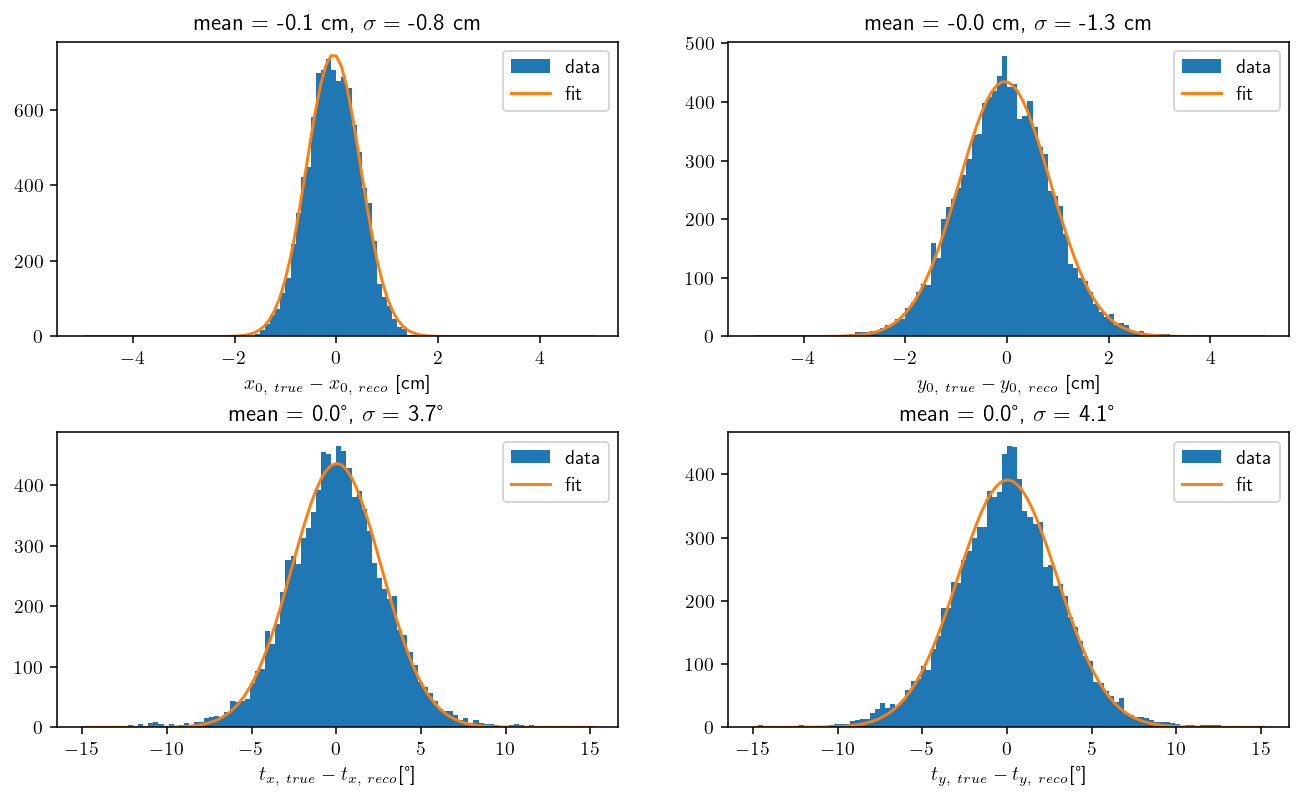

In [6]:
# compare fit precision
from scipy.optimize import curve_fit
bins = 100

offset_x0 = [true[0]-t.x.x0 for (true, t) in zip(true_parameters, tracks)]
hist_x0, bins_x0 = np.histogram(offset_x0, bins, range = [-5, 5])
bins_x0 = [b + (bins_x0[1] - bins_x0[0])/2 for b in bins_x0]
offset_y0 = [true[1] - t.y.x0 for (true, t) in zip(true_parameters, tracks)]
hist_y0, bins_y0 = np.histogram(offset_y0, bins, range = [-5, 5])
bins_y0 = [b + (bins_y0[1] - bins_y0[0])/2 for b in bins_y0]
offset_tx = [180 * (np.arctan(true[2]) - np.arctan(t.x.t)) / np.pi for (true, t) in zip(true_parameters, tracks)]
hist_tx, bins_tx = np.histogram(offset_tx, bins, range = [-15, 15])
bins_tx = [b + (bins_tx[1] - bins_tx[0])/2 for b in bins_tx]
offset_ty = [180 * (np.arctan(true[3]) - np.arctan(t.y.t)) / np.pi for (true, t) in zip(true_parameters, tracks)]
hist_ty, bins_ty = np.histogram(offset_ty, bins, range = [-15, 15])
bins_ty = [b + (bins_ty[1] - bins_ty[0])/2 for b in bins_ty]

# Define the Gaussian function
def Gauss(x, x0, sig, A):
    y = A*np.exp(-1*(x-x0)**2/(sig**2))
    return y

parameters_x0, _ = curve_fit(Gauss, bins_x0[:-1], hist_x0)
parameters_y0, _ = curve_fit(Gauss, bins_y0[:-1], hist_y0)
parameters_tx, _ = curve_fit(Gauss, bins_tx[:-1], hist_tx)
parameters_ty, _ = curve_fit(Gauss, bins_ty[:-1], hist_ty)


fig, axs = plt.subplots(2, 2, figsize = (10, 6))
fig.tight_layout(pad = 3)

axs[0, 0].set_title('mean = {:.1f} cm, $\sigma=$ {:.1f} cm'.format(parameters_x0[0], parameters_x0[1]))
axs[0, 0].hist(offset_x0, bins = bins, label = 'data', range = [-5, 5])
axs[0, 0].set_xlabel('$x_{0,\ true} - x_{0,\ reco}$ [cm]')
xs = np.linspace(np.min(bins_x0), np.max(bins_x0), 100)
axs[0, 0].plot(xs, Gauss(xs, parameters_x0[0], parameters_x0[1], parameters_x0[2]), label = 'fit')
axs[0, 0].legend()

axs[0, 1].set_title('mean = {:.1f} cm, $\sigma=$ {:.1f} cm'.format(parameters_y0[0], parameters_y0[1]))
axs[0, 1].hist(offset_y0, bins = bins, label = 'data', range = [-5, 5])
axs[0, 1].set_xlabel('$y_{0,\ true} - y_{0,\ reco}$ [cm]')
xs = np.linspace(np.min(bins_y0), np.max(bins_y0), 100)
axs[0, 1].plot(xs, Gauss(xs, parameters_y0[0], parameters_y0[1], parameters_y0[2]), label = 'fit')
axs[0, 1].legend()

axs[1, 0].set_title('mean = {:.1f}°, $\sigma=$ {:.1f}°'.format(parameters_tx[0], parameters_tx[1]))
axs[1, 0].hist(offset_tx, bins = bins, label = 'data', range = [-15, 15])
axs[1, 0].set_xlabel('$t_{x,\ true} - t_{x,\ reco}$[°]')
xs = np.linspace(np.min(bins_tx), np.max(bins_tx), 100)
axs[1, 0].plot(xs, Gauss(xs, parameters_tx[0], parameters_tx[1], parameters_tx[2]), label = 'fit')
axs[1, 0].legend()

axs[1, 1].set_title('mean = {:.1f}°, $\sigma=$ {:.1f}°'.format(parameters_ty[0], parameters_ty[1]))
axs[1, 1].hist(offset_ty, bins = bins, label = 'data', range = [-15, 15])
axs[1, 1].set_xlabel('$t_{y,\ true} - t_{y,\ reco}$[°]')
xs = np.linspace(np.min(bins_ty), np.max(bins_ty), 100)
axs[1, 1].plot(xs, Gauss(xs, parameters_ty[0], parameters_ty[1], parameters_ty[2]), label = 'fit')
axs[1, 1].legend()

# fig.show()


In [11]:
for t in tqdm(tracks[:5000]):
    t.precise_track()

100%|██████████| 5000/5000 [28:11<00:00,  2.96it/s]


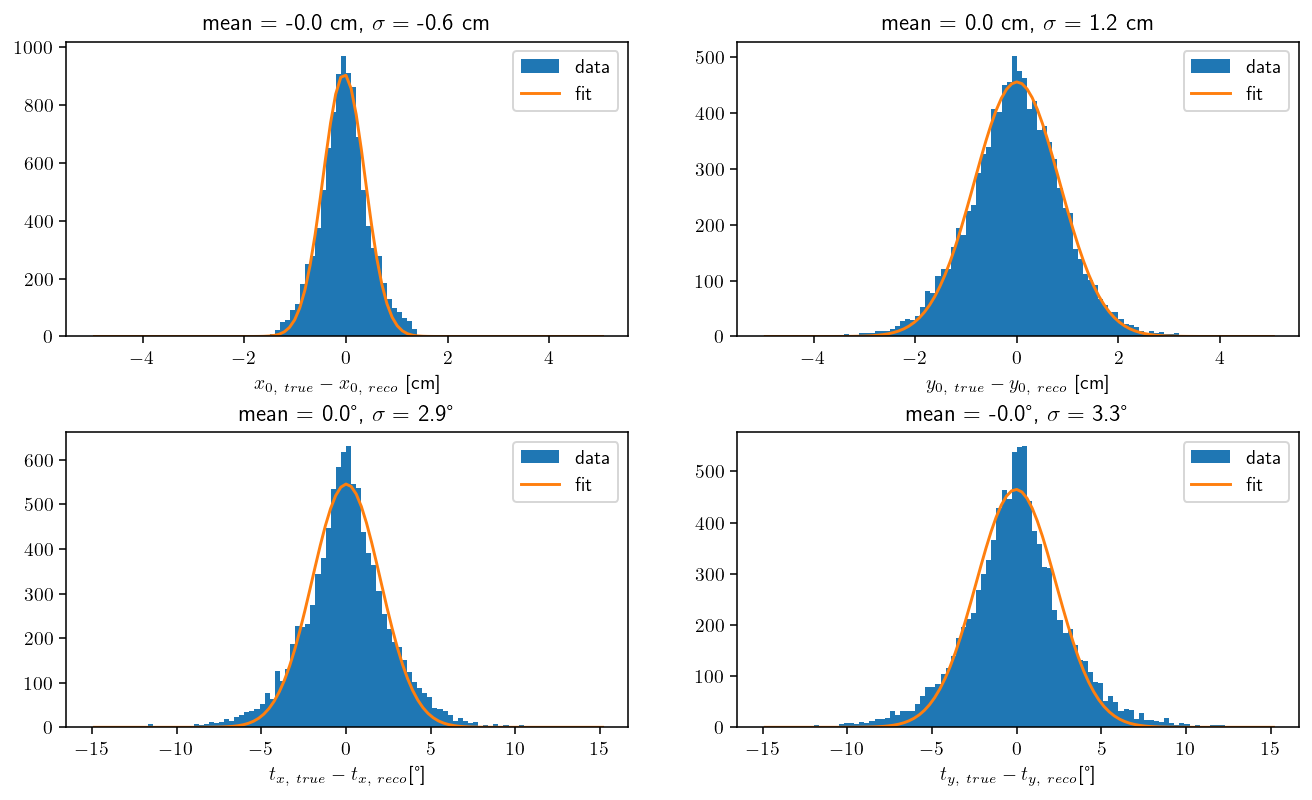

In [12]:
# compare fit precision
from scipy.optimize import curve_fit
bins = 100

offset_x0 = [true[0]-t.x.x0 for (true, t) in zip(true_parameters, tracks)]
hist_x0, bins_x0 = np.histogram(offset_x0, bins, range = [-5, 5])
bins_x0 = [b + (bins_x0[1] - bins_x0[0])/2 for b in bins_x0]
offset_y0 = [true[1] - t.y.x0 for (true, t) in zip(true_parameters, tracks)]
hist_y0, bins_y0 = np.histogram(offset_y0, bins, range = [-5, 5])
bins_y0 = [b + (bins_y0[1] - bins_y0[0])/2 for b in bins_y0]
offset_tx = [180 * (np.arctan(true[2]) - np.arctan(t.x.t)) / np.pi for (true, t) in zip(true_parameters, tracks)]
hist_tx, bins_tx = np.histogram(offset_tx, bins, range = [-15, 15])
bins_tx = [b + (bins_tx[1] - bins_tx[0])/2 for b in bins_tx]
offset_ty = [180 * (np.arctan(true[3]) - np.arctan(t.y.t)) / np.pi for (true, t) in zip(true_parameters, tracks)]
hist_ty, bins_ty = np.histogram(offset_ty, bins, range = [-15, 15])
bins_ty = [b + (bins_ty[1] - bins_ty[0])/2 for b in bins_ty]

# Define the Gaussian function
def Gauss(x, x0, sig, A):
    y = A*np.exp(-1*(x-x0)**2/(sig**2))
    return y

parameters_x0, _ = curve_fit(Gauss, bins_x0[:-1], hist_x0)
parameters_y0, _ = curve_fit(Gauss, bins_y0[:-1], hist_y0)
parameters_tx, _ = curve_fit(Gauss, bins_tx[:-1], hist_tx)
parameters_ty, _ = curve_fit(Gauss, bins_ty[:-1], hist_ty)


fig, axs = plt.subplots(2, 2, figsize = (10, 6))
fig.tight_layout(pad = 3)

axs[0, 0].set_title('mean = {:.1f} cm, $\sigma=$ {:.1f} cm'.format(parameters_x0[0], parameters_x0[1]))
axs[0, 0].hist(offset_x0, bins = bins, label = 'data', range = [-5, 5])
axs[0, 0].set_xlabel('$x_{0,\ true} - x_{0,\ reco}$ [cm]')
xs = np.linspace(np.min(bins_x0), np.max(bins_x0), 100)
axs[0, 0].plot(xs, Gauss(xs, parameters_x0[0], parameters_x0[1], parameters_x0[2]), label = 'fit')
axs[0, 0].legend()

axs[0, 1].set_title('mean = {:.1f} cm, $\sigma=$ {:.1f} cm'.format(parameters_y0[0], parameters_y0[1]))
axs[0, 1].hist(offset_y0, bins = bins, label = 'data', range = [-5, 5])
axs[0, 1].set_xlabel('$y_{0,\ true} - y_{0,\ reco}$ [cm]')
xs = np.linspace(np.min(bins_y0), np.max(bins_y0), 100)
axs[0, 1].plot(xs, Gauss(xs, parameters_y0[0], parameters_y0[1], parameters_y0[2]), label = 'fit')
axs[0, 1].legend()

axs[1, 0].set_title('mean = {:.1f}°, $\sigma=$ {:.1f}°'.format(parameters_tx[0], parameters_tx[1]))
axs[1, 0].hist(offset_tx, bins = bins, label = 'data', range = [-15, 15])
axs[1, 0].set_xlabel('$t_{x,\ true} - t_{x,\ reco}$[°]')
xs = np.linspace(np.min(bins_tx), np.max(bins_tx), 100)
axs[1, 0].plot(xs, Gauss(xs, parameters_tx[0], parameters_tx[1], parameters_tx[2]), label = 'fit')
axs[1, 0].legend()

axs[1, 1].set_title('mean = {:.1f}°, $\sigma=$ {:.1f}°'.format(parameters_ty[0], parameters_ty[1]))
axs[1, 1].hist(offset_ty, bins = bins, label = 'data', range = [-15, 15])
axs[1, 1].set_xlabel('$t_{y,\ true} - t_{y,\ reco}$[°]')
xs = np.linspace(np.min(bins_ty), np.max(bins_ty), 100)
axs[1, 1].plot(xs, Gauss(xs, parameters_ty[0], parameters_ty[1], parameters_ty[2]), label = 'fit')
axs[1, 1].legend()

# fig.show()
